<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/Model_training_YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision
!pip install ultralytics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create yolo dataset

In [ ]:
import os
import json

data_folder = "/content/drive/MyDrive/data/400_5816/"

# Load and check train annotations
train_json_path = os.path.join(data_folder, 'train.json')
with open(train_json_path) as f:
    train_data = json.load(f)
    print(f"Number of train annotations: {len(train_data['annotations'])}")
    print(f"Number of train images: {len(train_data['images'])}")

# Ensure the image paths are correct
missing_images = 0
for img in train_data['images']:
    img_path = os.path.join(data_folder, 'sliced_output_2020S', img['file_name'])
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        missing_images += 1

if missing_images > 0:
    print(f"Total missing images: {missing_images}")
else:
    print("All images found.")

# Check that annotations reference existing images
missing_annotations = 0
for ann in train_data['annotations']:
    img_id = ann['image_id']
    img_info = next((img for img in train_data['images'] if img['id'] == img_id), None)
    if img_info is None:
        print(f"Annotation references missing image ID {img_id}")
        missing_annotations += 1

if missing_annotations > 0:
    print(f"Total missing annotations: {missing_annotations}")
else:
    print("All annotations reference existing images.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/400_5816/train.json'

File Structure
```
/content/drive/MyDrive/data/400_5816/
  ├── sliced_output_2020S/             # All images (both train and val)
  ├── yolov8_labels_train/             # Labels for training images
  ├── yolov8_labels_val/               # Labels for validation images
  ├── train_images.txt                 # List of training image paths
  ├── val_images.txt                   # List of validation image paths
  └── dataset.yaml                     # Dataset configuration file
```



In [ ]:
import os
import shutil
import json
import numpy as np
from tqdm import tqdm

def convert_coco_to_yolov8(coco_file, output_folder):
    with open(coco_file) as f:
        coco = json.load(f)

    images = {img['id']: img for img in coco['images']}
    annotations = coco['annotations']
    categories = {cat['id']: cat['name'] for cat in coco['categories']}

    os.makedirs(output_folder, exist_ok=True)

    for ann in tqdm(annotations, desc='Converting annotations'):
        image_id = ann['image_id']
        image = images[image_id]
        filename = image['file_name']
        label_filename = os.path.splitext(os.path.basename(filename))[0]  # Get filename without path and extension
        label_path = os.path.join(output_folder, f'{label_filename}.txt')

        img_width = float(image['width'])
        img_height = float(image['height'])
        label_id = ann['category_id']

        # Handle multiple polygons per annotation
        if isinstance(ann['segmentation'], list):
            polygons = ann['segmentation']
            if isinstance(polygons[0], list):
                # Handle multiple polygons
                segmentation_points = []
                for polygon in polygons:
                    segmentation_points.extend(polygon)
            else:
                segmentation_points = polygons
        else:
            segmentation_points = ann['segmentation']

        if not segmentation_points:
            continue

        # Ensure the segmentation points are in the correct format and type
        try:
            segment = np.array(segmentation_points, dtype=float).reshape(-1, 2)
            segment[:, 0] = segment[:, 0] / img_width
            segment[:, 1] = segment[:, 1] / img_height
            segmentation_points = segment.flatten().tolist()
        except Exception as e:
            print(f"Error in segmentation normalization: {e}")
            continue

        segmentation_points_str = ' '.join(f"{x:.6f}" for x in segmentation_points)

        line = '{} {}'.format(label_id, segmentation_points_str)

        # Append the label in YOLOv8 format
        with open(label_path, 'a') as f:  # Use 'a' to append if there are multiple objects
            f.write(line + '\n')

In [ ]:
data_folder = "/content/drive/MyDrive/data/400_5816/"
dataset_folder = os.path.join(data_folder, 'yolo_dataset')
train_images_folder = os.path.join(dataset_folder, 'train/images')
train_labels_folder = os.path.join(dataset_folder, 'train/labels')
val_images_folder = os.path.join(dataset_folder, 'val/images')
val_labels_folder = os.path.join(dataset_folder, 'val/labels')

# Create the directories if they don't exist
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)

# Convert COCO JSON to YOLOv8 format and save to separate folders
convert_coco_to_yolov8(os.path.join(data_folder, 'train.json'), train_labels_folder)
convert_coco_to_yolov8(os.path.join(data_folder, 'val.json'), val_labels_folder)

# Move images to the corresponding directories
def move_images(coco_file, images_folder):
    with open(coco_file) as f:
        coco = json.load(f)
    for img in coco['images']:
        filename = os.path.basename(img['file_name'])  # Extract filename from full path
        src_path = os.path.join(data_folder, 'sliced_output_2020S', filename)
        dst_path = os.path.join(images_folder, filename)
        shutil.copy(src_path, dst_path)

# Move the images
#move_images(os.path.join(data_folder, 'train.json'), train_images_folder)
#move_images(os.path.join(data_folder, 'val.json'), val_images_folder)

# Create data.yaml
yaml_content = f"""
path: {dataset_folder}
train: train/images
val: val/images
nc: 1
names: ['tree_crown']
"""

yaml_file_path = os.path.join(dataset_folder, "data.yaml")
with open(yaml_file_path, "w") as file:
    file.write(yaml_content)

print("Dataset organized and data.yaml created.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/400_5816/train.json'

# TRAINING

In [5]:
import os

data_folder = "/content/drive/MyDrive/data/400_5816/"
dataset_folder = os.path.join(data_folder, 'yolo_dataset')
yaml_file_path = os.path.join(dataset_folder, "data.yaml")

In [6]:
import yaml
import cv2
import matplotlib.pyplot as plt

# Load the data.yaml file
yaml_file_path = '/content/drive/MyDrive/data/400_5816/yolo_dataset/data.yaml'  # Update this path to your actual data.yaml file

with open(yaml_file_path, 'r') as file:
    data_config = yaml.safe_load(file)

# Extract paths from the YAML file
base_path = data_config['path']
train_images_path = os.path.join(base_path, data_config['train'])
train_labels_path = train_images_path.replace('images', 'labels')

# Get a list of images and labels
image_files = os.listdir(train_images_path)
label_files = os.listdir(train_labels_path)

# Print available label files to debug
print("Available label files:", label_files)

# Choose an image to visualize
image_name = image_files[0]  # You can change this to visualize a different image
image_path = os.path.join(train_images_path, image_name)

# Attempt to locate the corresponding label file
label_name = image_name.rsplit('.', 1)[0] + '.txt'
label_path = os.path.join(train_labels_path, label_name)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Available label files: ['3dm_33_400_5817_1_be_nobuild_2_3.txt', '3dm_33_400_5816_1_be_nobuild_5_3.txt', '3dm_33_401_5817_1_be_nobuild_3_7.txt', '3dm_33_400_5816_1_be_nobuild_7_4.txt', '3dm_33_401_5816_1_be_nobuild_3_3.txt', '3dm_33_400_5817_1_be_nobuild_4_6.txt', '3dm_33_400_5817_1_be_nobuild_4_8.txt', '3dm_33_401_5816_1_be_nobuild_3_7.txt', '3dm_33_401_5817_1_be_nobuild_9_0.txt', '3dm_33_400_5816_1_be_nobuild_1_4.txt', '3dm_33_400_5817_1_be_nobuild_1_3.txt', '3dm_33_401_5816_1_be_nobuild_0_4.txt', '3dm_33_401_5816_1_be_nobuild_5_8.txt', '3dm_33_401_5816_1_be_nobuild_2_3.txt', '3dm_33_400_5816_1_be_nobuild_5_6.txt', '3dm_33_401_5816_1_be_nobuild_7_7.txt', '3dm_33_400_5817_1_be_nobuild_0_3.txt', '3dm_33_401_5816_1_be_nobuild_2_0.txt', '3dm_33_401_5817_1_be_nobuild_2_9.txt', '3dm_33_401_5816_1_be_nobuild_0_9.txt', '3dm_33_401_5816_1_be_nobuild_3_2.txt', '3dm_33_401_5817_1_be_nobuild_9_2.txt', '3dm_33_401_5817_1_be_nobuild_3_1.txt', '3dm_33_400_5817_1_be_nobuild_7_2.txt', '3dm_33_401_5816

Line 1: 0 0.702000 0.902000 0.694000 0.910000 0.694000 0.912000 0.688000 0.918000 0.688000 0.926000 0.686000 0.928000 0.686000 0.938000 0.692000 0.944000 0.692000 0.946000 0.700000 0.954000 0.702000 0.954000 0.704000 0.952000 0.710000 0.952000 0.712000 0.950000 0.718000 0.950000 0.720000 0.948000 0.722000 0.948000 0.722000 0.946000 0.726000 0.942000 0.728000 0.942000 0.732000 0.938000 0.732000 0.932000 0.734000 0.930000 0.734000 0.924000 0.732000 0.922000 0.732000 0.920000 0.728000 0.916000 0.728000 0.914000 0.726000 0.912000 0.724000 0.912000 0.722000 0.910000 0.720000 0.910000 0.718000 0.908000 0.714000 0.908000 0.712000 0.906000 0.710000 0.906000 0.708000 0.904000 0.706000 0.904000 0.704000 0.902000
Line 2: 0 0.034000 0.000000 0.034000 0.008000 0.032000 0.010000 0.032000 0.024000 0.030000 0.026000 0.030000 0.062000 0.032000 0.062000 0.034000 0.060000 0.038000 0.060000 0.040000 0.058000 0.044000 0.058000 0.046000 0.056000 0.050000 0.056000 0.052000 0.054000 0.056000 0.054000 0.058000

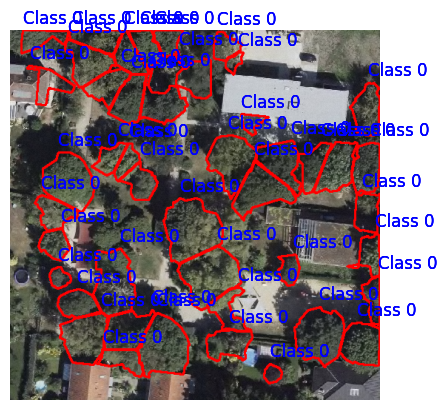

In [ ]:
import numpy as np

# Inspect the first few lines of the label file
with open(label_path, 'r') as file:
    for i in range(5):
        print(f"Line {i+1}: {file.readline().strip()}")

# Adjust the label parsing based on the format
with open(label_path, 'r') as file:
    labels = file.readlines()

# Process each label
for label in labels:
    values = label.strip().split()

    if len(values) < 3:
        print(f"Unexpected number of values in label: {values}")
        continue

    class_id = int(values[0])
    coordinates = list(map(float, values[1:]))

    # Ensure there are an even number of coordinates
    if len(coordinates) % 2 != 0:
        print(f"Odd number of coordinates in label: {values}")
        continue

    # Convert from normalized coordinates to pixel coordinates
    img_height, img_width = image.shape[:2]
    polygon_points = []

    for i in range(0, len(coordinates), 2):
        x = int(coordinates[i] * img_width)
        y = int(coordinates[i + 1] * img_height)
        polygon_points.append((x, y))

    # Convert list of points to a numpy array for cv2.polylines
    polygon_points = np.array(polygon_points, np.int32)
    polygon_points = polygon_points.reshape((-1, 1, 2))

    # Draw the polygon on the image
    cv2.polylines(image, [polygon_points], isClosed=True, color=(255, 0, 0), thickness=2)

    # Optionally, put the class label on the image
    plt.text(polygon_points[0][0][0], polygon_points[0][0][1] - 10, f'Class {class_id}', color='blue', fontsize=12)

# Show the image with annotations
print(image_name)
plt.imshow(image)
plt.axis('off')
plt.show()

Total number of labels: 136
Unique labels: 45
Duplicated labels: 91

Duplication Overview:
Occurrences | Number of Labels
3            | 44
4            | 1

Duplicate labels found in /content/drive/MyDrive/data/400_5816/yolo_dataset/train/labels/3dm_33_400_5816_1_be_nobuild_5_3.txt:
Class 0: (0.702, 0.902, 0.694, 0.91, 0.694, 0.912, 0.688, 0.918, 0.688, 0.926, 0.686, 0.928, 0.686, 0.938, 0.692, 0.944, 0.692, 0.946, 0.7, 0.954, 0.702, 0.954, 0.704, 0.952, 0.71, 0.952, 0.712, 0.95, 0.718, 0.95, 0.72, 0.948, 0.722, 0.948, 0.722, 0.946, 0.726, 0.942, 0.728, 0.942, 0.732, 0.938, 0.732, 0.932, 0.734, 0.93, 0.734, 0.924, 0.732, 0.922, 0.732, 0.92, 0.728, 0.916, 0.728, 0.914, 0.726, 0.912, 0.724, 0.912, 0.722, 0.91, 0.72, 0.91, 0.718, 0.908, 0.714, 0.908, 0.712, 0.906, 0.71, 0.906, 0.708, 0.904, 0.706, 0.904, 0.704, 0.902)
Class 0: (0.034, 0.0, 0.034, 0.008, 0.032, 0.01, 0.032, 0.024, 0.03, 0.026, 0.03, 0.062, 0.032, 0.062, 0.034, 0.06, 0.038, 0.06, 0.04, 0.058, 0.044, 0.058, 0.046, 0.056, 0.

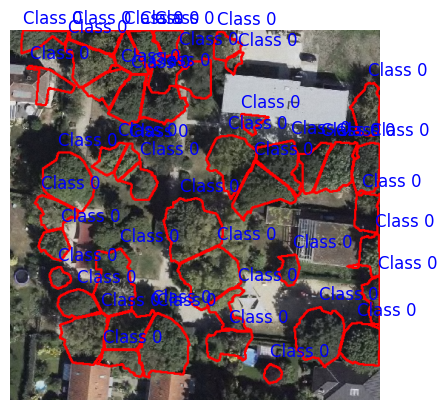

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter

# Path to the label file
label_path = '/content/drive/MyDrive/data/400_5816/yolo_dataset/train/labels/3dm_33_400_5816_1_be_nobuild_5_3.txt'
image_path = '/content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_5_3.tif'

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the labels
with open(label_path, 'r') as file:
    labels = file.readlines()

# Store and check duplicates
label_dict = Counter()
duplicate_labels = []

for label in labels:
    values = label.strip().split()

    if len(values) < 3:
        print(f"Unexpected number of values in label: {values}")
        continue

    class_id = int(values[0])
    coordinates = tuple(map(float, values[1:]))  # Store as a tuple for easy comparison

    label_dict[(class_id, coordinates)] += 1  # Count occurrences

    if label_dict[(class_id, coordinates)] > 1:
        duplicate_labels.append((class_id, coordinates))

# Total number of labels
total_labels = len(labels)
print(f"Total number of labels: {total_labels}")

# Unique labels
unique_labels = len(label_dict)
print(f"Unique labels: {unique_labels}")

# Duplicated labels
duplicate_count = len(duplicate_labels)
print(f"Duplicated labels: {duplicate_count}")

# Overview of duplications
duplication_overview = Counter(label_dict.values())
print("\nDuplication Overview:")
print("Occurrences | Number of Labels")
for occurrence, num_labels in sorted(duplication_overview.items()):
    print(f"{occurrence:<12} | {num_labels}")

# Print out the duplicates
if duplicate_labels:
    print(f"\nDuplicate labels found in {label_path}:")
    for class_id, coordinates in duplicate_labels:
        print(f"Class {class_id}: {coordinates}")
else:
    print("No duplicate labels found.")

# Draw the annotations on the image
for (class_id, coordinates), count in label_dict.items():
    if count > 1:
        print(f"Class {class_id} with coordinates {coordinates} appears {count} times.")

    # Convert from normalized coordinates to pixel coordinates
    img_height, img_width = image.shape[:2]
    polygon_points = []

    for i in range(0, len(coordinates), 2):
        x = int(coordinates[i] * img_width)
        y = int(coordinates[i + 1] * img_height)
        polygon_points.append((x, y))

    # Convert list of points to a numpy array for cv2.polylines
    polygon_points = np.array(polygon_points, np.int32)
    polygon_points = polygon_points.reshape((-1, 1, 2))

    # Draw the polygon on the image
    color = (255, 0, 0) if count > 1 else (0, 255, 0)
    cv2.polylines(image, [polygon_points], isClosed=True, color=color, thickness=2)

    # Optionally, put the class label on the image
    plt.text(polygon_points[0][0][0], polygon_points[0][0][1] - 10, f'Class {class_id}', color='blue', fontsize=12)

# Show the image with annotations
plt.imshow(image)
plt.axis('off')
plt.show()



In [ ]:
import torch
from ultralytics import YOLO

# Load YOLOv8 model
#model = YOLO('yolov8n-seg.pt')
model = YOLO('yolov8m-seg.pt')

100%|██████████| 52.4M/52.4M [00:00<00:00, 96.4MB/s]


In [ ]:
# Hyperparameters
learning_rate = 0.001  # Adjusted learning rate for AdamW optimizer
num_epochs = 300  # Adjusted number of epochs
image_size = 640  # Image size

# Start training with built-in early stopping and LR scheduler
model.train(
    data=yaml_file_path,  # Path to your data.yaml file
    epochs=num_epochs,  # Number of training epochs
    imgsz=image_size,  # Image size
    lr0=learning_rate,  # Initial learning rate
    patience=30,  # Early stopping patience
    save_period=5,  # Save model every 5 epochs to reduce storage load
    optimizer='AdamW',  # Optimizer
    weight_decay=0.0005,  # Weight decay for regularization
)


Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/content/drive/MyDrive/data/400_5816/yolo_dataset/data.yaml, epochs=300, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 97.0MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/data/400_5816/yolo_dataset/train/labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_0_0.tif: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_1_3.tif: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_1_4.tif: 89 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_1_5.tif: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_4_0.tif: 79 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_4_1.tif: 49 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/train/images/3dm_33_400_5816_1_be_nobuild_5_3.tif: 91

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/data/400_5816/yolo_dataset/val/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5816_1_be_nobuild_5_8.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_0_5.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_0_6.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_1_2.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_1_4.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_1_6.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_2_5.tif: 1 duplicate labels removed
val: W

Plotting labels to runs/segment/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/300      10.6G      3.166      5.655      3.955      2.772        532        640: 100%|██████████| 6/6 [00:29<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]

                   all         23       1158     0.0252       0.15     0.0172    0.00497    0.00783     0.0466    0.00442    0.00102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/300        10G      2.712      4.768      2.509      2.418        558        640: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         23       1158      0.031      0.185     0.0184    0.00601   0.000381   0.000864   0.000147    2.2e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/300      10.4G      2.525      4.268      2.124      2.103        528        640: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         23       1158       0.14     0.0793     0.0656     0.0209    0.00646     0.0371    0.00328   0.000827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/300      10.9G      2.448      4.109      2.033      2.085        542        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         23       1158       0.18      0.342       0.13     0.0356     0.0039     0.0095    0.00136   0.000262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/300      10.3G      2.417      4.078      1.969      2.067        645        640: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         23       1158     0.0518      0.137     0.0352     0.0103     0.0103     0.0311    0.00475    0.00131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/300      10.4G      2.336      4.011      2.059       2.05        443        640: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         23       1158      0.191      0.333       0.16     0.0457    0.00352      0.019    0.00172   0.000342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/300        10G      2.298      3.976      1.985       2.05        489        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all         23       1158      0.187      0.145     0.0926     0.0234   0.000221   0.000864   7.36e-05   1.47e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/300      10.6G      2.325      3.936      1.896      1.995        512        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         23       1158      0.266      0.176      0.139      0.038    0.00432    0.00259   0.000624   0.000188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/300        11G      2.363      3.965      1.914      2.012        593        640: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all         23       1158      0.215      0.262      0.158     0.0442    0.00695    0.00691    0.00357   0.000503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/300      9.74G       2.34      3.906      1.947      1.998        378        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         23       1158      0.288      0.245      0.207      0.062     0.0174    0.00691    0.00255   0.000715



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/300      10.5G      2.326      3.953      1.887      1.918        524        640: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         23       1158        0.3      0.196      0.167     0.0494      0.163     0.0328     0.0227     0.0045



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/300      10.6G      2.366      3.946      1.941      2.024        426        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all         23       1158      0.331      0.263      0.213     0.0602      0.132     0.0639     0.0451    0.00985



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/300      10.2G      2.311      3.952      1.845       1.97        407        640: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         23       1158      0.267      0.234      0.174     0.0492      0.147     0.0933     0.0558      0.012



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/300      10.8G       2.32      3.953      1.838      1.961        610        640: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all         23       1158      0.176      0.116     0.0857     0.0256     0.0833     0.0354     0.0244    0.00501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/300      10.2G      2.278      3.878      1.899       1.99        459        640: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         23       1158      0.204      0.225      0.156      0.044      0.115     0.0484     0.0351    0.00735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/300      10.7G      2.295      3.902      1.904       2.02        362        640: 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all         23       1158      0.332      0.359      0.276     0.0816      0.231     0.0981     0.0844     0.0202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.1G      2.279      3.858       1.84      1.996        445        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

                   all         23       1158      0.253      0.278      0.191     0.0538      0.205      0.105       0.07     0.0165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/300        11G      2.239      3.839      1.863       1.94        364        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         23       1158      0.116     0.0769     0.0375    0.00894      0.106     0.0682     0.0313    0.00745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/300      10.1G      2.276      3.841       1.89      1.936        707        640: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

                   all         23       1158      0.219      0.146     0.0916     0.0249      0.245     0.0976     0.0652     0.0164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/300      10.4G      2.213      3.848      1.819      1.921        442        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         23       1158      0.317      0.323      0.254     0.0686      0.288      0.202      0.157     0.0385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/300      10.8G      2.207      3.791      1.788      1.911        491        640: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         23       1158      0.384      0.332      0.275     0.0751      0.294      0.216      0.158     0.0413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/300      10.7G      2.221      3.781      1.799      1.921        430        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all         23       1158      0.317      0.312      0.233     0.0605      0.224      0.183       0.13     0.0325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/300      9.82G      2.229      3.762      1.833      1.978        618        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         23       1158      0.329      0.312      0.246     0.0722      0.278      0.187       0.15     0.0377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/300      10.2G      2.224      3.744      1.768      1.912        647        640: 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all         23       1158      0.288      0.286      0.218     0.0612      0.227      0.187      0.136     0.0338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/300      10.1G      2.217      3.726      1.803      1.862        477        640: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         23       1158      0.303      0.329       0.24     0.0671      0.224      0.218       0.15     0.0366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/300      9.79G      2.248      3.807      1.826      1.931        539        640: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         23       1158      0.328      0.294      0.244     0.0719      0.285      0.206      0.161     0.0438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/300      10.4G      2.201      3.775       1.77      1.892        470        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

                   all         23       1158      0.341      0.296      0.255     0.0723      0.299      0.215      0.177     0.0455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/300      9.88G      2.159      3.737      1.806      1.917        399        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         23       1158      0.354      0.373      0.307     0.0885      0.317      0.257      0.222     0.0566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/300      10.2G      2.197      3.762      1.716      1.892        629        640: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all         23       1158       0.31      0.364      0.267     0.0751      0.265      0.254      0.198     0.0484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/300        10G      2.239      3.709      1.683      1.858        539        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         23       1158      0.317      0.313       0.24     0.0652       0.26      0.233      0.158     0.0365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/300      10.8G      2.201      3.699      1.678      1.865        471        640: 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all         23       1158       0.33      0.318      0.254     0.0705      0.275      0.225      0.164     0.0391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/300      10.7G      2.133      3.683      1.766      1.896        404        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         23       1158      0.344      0.335      0.288     0.0869      0.269      0.248      0.196     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/300        10G      2.146      3.717      1.741      1.904        534        640: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         23       1158      0.354      0.364      0.305     0.0918      0.312      0.265      0.204     0.0546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/300      10.2G      2.147      3.683      1.758      1.897        569        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         23       1158       0.38      0.341      0.303     0.0916      0.286      0.232      0.191     0.0493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/300      10.9G      2.119      3.689      1.759      1.893        250        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         23       1158      0.381      0.347      0.307     0.0942      0.326      0.228      0.194     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/300      10.8G      2.156      3.641      1.666      1.841        733        640: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         23       1158      0.355      0.311      0.258     0.0753      0.265      0.232      0.167     0.0425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/300      10.5G      2.098      3.581      1.656      1.818        328        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         23       1158      0.335      0.294      0.244     0.0685      0.247      0.213      0.156     0.0383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/300      10.3G      2.121      3.646      1.696      1.874        378        640: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all         23       1158      0.364      0.328      0.282      0.084      0.345      0.226      0.196     0.0509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/300        11G      2.132      3.595      1.612      1.838        407        640: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all         23       1158      0.431      0.332      0.333      0.101      0.402      0.242      0.235     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/300      10.8G      2.163      3.603      1.637      1.863        397        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         23       1158      0.349      0.387        0.3     0.0796      0.316      0.281      0.219     0.0536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/300      9.54G      2.171      3.656      1.718      1.922        373        640: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all         23       1158       0.37      0.373      0.302     0.0803       0.32      0.283      0.217     0.0514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/300      10.2G      2.104      3.636      1.728      1.901        359        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         23       1158      0.379      0.353      0.294     0.0831      0.322       0.25      0.204     0.0515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/300      10.6G      2.079      3.607      1.689      1.887        485        640: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         23       1158      0.394       0.36      0.315       0.09       0.34       0.24      0.207     0.0536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/300      10.5G      2.108      3.592      1.645      1.896        449        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

                   all         23       1158      0.368      0.343      0.291     0.0774      0.313      0.242      0.208     0.0507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/300      10.8G      2.076      3.538      1.643      1.852        349        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         23       1158      0.349      0.355      0.284     0.0768      0.284      0.275      0.216      0.053



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/300      10.3G      2.064      3.582      1.662      1.883        344        640: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all         23       1158      0.373       0.38      0.323     0.0862      0.324      0.285       0.24     0.0596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/300      10.2G      2.073      3.601      1.605      1.857        512        640: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         23       1158      0.328      0.327      0.277     0.0712      0.286      0.259      0.206     0.0515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/300      9.94G      2.061      3.498      1.592      1.834        425        640: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all         23       1158      0.297       0.29      0.226      0.062      0.258      0.243      0.178     0.0438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/300      10.3G      2.054      3.542      1.594      1.848        444        640: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         23       1158      0.347      0.327      0.256     0.0701      0.296      0.282      0.205     0.0487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/300      10.8G      2.063       3.51      1.521       1.81        493        640: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         23       1158       0.35      0.345      0.275     0.0761       0.31      0.307      0.229     0.0572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/300      9.99G      2.041      3.452      1.548      1.824        431        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         23       1158       0.39      0.356       0.31     0.0864      0.337      0.302      0.238     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/300      10.4G      1.969      3.431      1.515        1.8        466        640: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         23       1158      0.369      0.369      0.307     0.0871      0.313        0.3       0.23     0.0581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/300      10.2G      2.046      3.503      1.584      1.844        498        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all         23       1158      0.371      0.381      0.313     0.0899      0.309      0.307      0.244     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/300      11.1G      2.004      3.474       1.54      1.786        414        640: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         23       1158      0.335      0.353      0.288     0.0823      0.303      0.282       0.23     0.0598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/300      10.1G      1.981      3.407      1.466      1.765        476        640: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         23       1158      0.282      0.358      0.261      0.075      0.267      0.263      0.207     0.0542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/300      10.1G      2.024      3.461      1.549      1.809        583        640: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         23       1158      0.374      0.354      0.305     0.0883       0.31      0.283      0.226     0.0562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/300      10.1G       1.98      3.463      1.483      1.772        458        640: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all         23       1158      0.404      0.335      0.322     0.0904       0.31      0.264      0.223     0.0569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/300      10.6G      1.995      3.427        1.5      1.774        389        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         23       1158      0.404      0.345      0.329     0.0957      0.374      0.268      0.229     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/300      10.3G      1.944      3.353      1.449      1.729        522        640: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         23       1158      0.415      0.358       0.33     0.0932      0.346       0.28      0.226     0.0595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/300      11.6G      1.951       3.37      1.455      1.751        374        640: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all         23       1158       0.41      0.362      0.337     0.0958      0.371      0.282      0.246     0.0625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/300      10.4G      1.947      3.359      1.405      1.736        543        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         23       1158      0.398      0.342      0.317     0.0913      0.349      0.288       0.24     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/300      10.2G      1.932       3.35      1.424      1.763        371        640: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         23       1158      0.355      0.342      0.295     0.0821      0.341      0.267      0.223     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/300      9.81G      1.975      3.384       1.38      1.735        617        640: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         23       1158      0.401        0.3      0.295     0.0829      0.354      0.245       0.22     0.0562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/300      10.6G       1.98      3.375      1.381       1.75        688        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         23       1158      0.416      0.354      0.338     0.0968       0.38      0.271      0.241     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/300      9.72G      1.936      3.343      1.423      1.781        476        640: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         23       1158      0.446      0.371      0.356     0.0999      0.347      0.297      0.241     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/300      10.7G      1.922      3.347      1.437      1.796        437        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all         23       1158      0.404      0.388      0.335     0.0927      0.339      0.309      0.246     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/300      10.5G      1.884      3.298      1.382      1.713        468        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         23       1158       0.35       0.36      0.286     0.0768      0.318      0.298      0.224     0.0554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/300      9.95G      1.884      3.306       1.38      1.706        471        640: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all         23       1158      0.488      0.338      0.341     0.0967      0.412      0.271      0.251     0.0601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/300       9.9G      1.879      3.288      1.396      1.757        300        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         23       1158      0.421      0.338      0.316     0.0922      0.363      0.254      0.223     0.0568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/300      10.7G      1.852       3.23      1.315      1.664        417        640: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         23       1158      0.326      0.373      0.298     0.0808      0.293      0.294      0.224     0.0561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/300      10.4G       1.93      3.291      1.429      1.764        356        640: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all         23       1158       0.32      0.367      0.286     0.0783      0.282      0.292      0.219     0.0552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/300      10.3G      1.947      3.317      1.429      1.751        349        640: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         23       1158      0.351       0.41       0.32     0.0918       0.29      0.324      0.237     0.0613



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/300      10.7G      1.822      3.158      1.299      1.677        318        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         23       1158      0.392      0.404      0.342     0.0998      0.327      0.304       0.25     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/300      10.5G      1.885      3.194      1.302      1.715        390        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         23       1158      0.349      0.378      0.305     0.0857      0.306      0.298      0.227     0.0567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/300      10.3G      1.827      3.191      1.309      1.699        301        640: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all         23       1158      0.358       0.37      0.294     0.0829      0.302      0.309      0.218     0.0548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/300      10.6G      1.838       3.16      1.281      1.691        386        640: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         23       1158      0.389      0.377       0.33     0.0966      0.335      0.295       0.23     0.0602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/300      10.4G      1.807      3.208      1.301      1.683        429        640: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         23       1158      0.446      0.355      0.337     0.0966      0.359      0.277      0.226     0.0589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/300      10.3G      1.788      3.133      1.255      1.651        373        640: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         23       1158      0.385      0.368      0.305     0.0853      0.319      0.294      0.215     0.0549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/300      10.1G      1.815      3.209      1.293      1.692        333        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         23       1158      0.334      0.337       0.26     0.0707      0.272      0.263      0.181     0.0453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/300      10.7G      1.741      3.083       1.21      1.612        427        640: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         23       1158      0.366      0.335      0.276     0.0778      0.315      0.263      0.203     0.0486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.5G      1.757      3.134       1.21      1.622        473        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         23       1158      0.373      0.357      0.289     0.0824      0.302      0.289      0.214     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/300      10.6G      1.711      3.014      1.165      1.582        590        640: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         23       1158      0.338      0.354      0.269     0.0709       0.29      0.286      0.202     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/300      10.1G      1.724       2.98      1.167      1.612        375        640: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         23       1158      0.383      0.357      0.292     0.0796      0.326      0.275      0.209      0.052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/300        10G      1.692      2.966      1.133      1.589        482        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         23       1158      0.427      0.362       0.33     0.0926      0.336      0.278      0.221     0.0578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/300      9.85G      1.763      3.087      1.203      1.657        365        640: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all         23       1158      0.384      0.373       0.32     0.0927      0.351      0.273      0.222      0.057



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/300      10.7G      1.721      3.042      1.166      1.618        544        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         23       1158      0.311      0.403      0.275     0.0754      0.263      0.283      0.191      0.045



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/300      10.4G      1.722      3.004      1.172      1.599        357        640: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         23       1158      0.347      0.391       0.29     0.0784      0.281      0.288      0.206     0.0505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/300      10.8G      1.701      2.997      1.143      1.592        349        640: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         23       1158      0.373      0.403      0.314     0.0861      0.306      0.302      0.222     0.0543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/300      10.2G      1.664      2.918      1.111      1.568        414        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         23       1158      0.409      0.368      0.315      0.087      0.337      0.288      0.229     0.0558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/300      10.5G      1.664      2.911      1.118      1.572        536        640: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all         23       1158      0.416      0.378      0.327      0.092      0.366      0.288      0.242     0.0567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/300      10.5G      1.674      2.916      1.089      1.555        538        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         23       1158      0.412      0.428      0.345     0.0942      0.356      0.312      0.239     0.0554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/300      9.96G      1.626      2.863      1.081      1.563        406        640: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         23       1158      0.442      0.367      0.318     0.0871      0.366      0.288       0.23     0.0537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/300      10.3G      1.612       2.88      1.062      1.531        421        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         23       1158      0.391       0.37      0.317     0.0888      0.341      0.296      0.228     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/300      10.1G      1.601      2.831      1.029      1.499        308        640: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         23       1158      0.365      0.374      0.289     0.0778      0.289      0.282      0.205     0.0494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/300      10.1G       1.71      3.009      1.141      1.603        440        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all         23       1158      0.341      0.364      0.266     0.0702       0.27      0.291      0.181     0.0441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/300      10.5G      1.573      2.843      1.028      1.514        520        640: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         23       1158      0.357      0.371      0.293     0.0791      0.288        0.3      0.215     0.0513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/300      10.8G      1.596      2.809     0.9987      1.491        483        640: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all         23       1158      0.347      0.355      0.274     0.0738       0.27      0.277      0.192     0.0488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/300      10.2G      1.618      2.837          1      1.518        430        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         23       1158      0.359      0.366      0.281     0.0767      0.314      0.263      0.205     0.0485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/300      10.6G       1.56       2.77     0.9869      1.461        692        640: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         23       1158      0.347      0.362      0.274     0.0743      0.272      0.296      0.203     0.0487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/300      9.96G      1.601      2.794      1.006      1.511        616        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         23       1158      0.329      0.368      0.267     0.0738      0.286       0.27      0.196     0.0495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/300      9.76G      1.551       2.77     0.9884      1.494        338        640: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         23       1158      0.311      0.357      0.254      0.069      0.269      0.285      0.192     0.0468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/300      9.96G      1.543      2.778     0.9704      1.462        620        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         23       1158      0.328        0.4      0.289     0.0764      0.319      0.265      0.207     0.0495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/300      9.91G      1.528      2.729      0.974       1.48        491        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         23       1158      0.381       0.37      0.313     0.0826      0.292      0.279      0.212      0.052
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 73, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



103 epochs completed in 0.319 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


                   all         23       1158      0.395      0.392      0.342     0.0997      0.327      0.303      0.251     0.0642
Speed: 0.3ms preprocess, 14.6ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e982cbb9d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [ ]:
model_name = "yolov8n_seg_trained_model.pt"
model_dir = os.path.join(data_folder, 'yolo_models')
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, model_name)
model.save(model_path)

In [ ]:
# Evaluate the model on the validation set
metrics = model.val(data=yaml_file_path)

# Print evaluation metrics
print(metrics)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/data/400_5816/yolo_dataset/val/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5816_1_be_nobuild_5_8.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_0_5.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_0_6.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_1_2.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_1_4.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_1_6.tif: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/400_5816/yolo_dataset/val/images/3dm_33_400_5817_1_be_nobuild_2_5.tif: 1 duplicate labels removed
val: W


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


                   all         23       1158      0.392      0.409      0.341     0.0997      0.318      0.308       0.25     0.0641
Speed: 0.7ms preprocess, 66.0ms inference, 0.0ms loss, 15.9ms postprocess per image
Results saved to runs/segment/train2
ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e982ca067d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022, 


0: 640x640 54 tree_crowns, 50.4ms
Speed: 3.5ms preprocess, 50.4ms inference, 20.4ms postprocess per image at shape (1, 3, 640, 640)


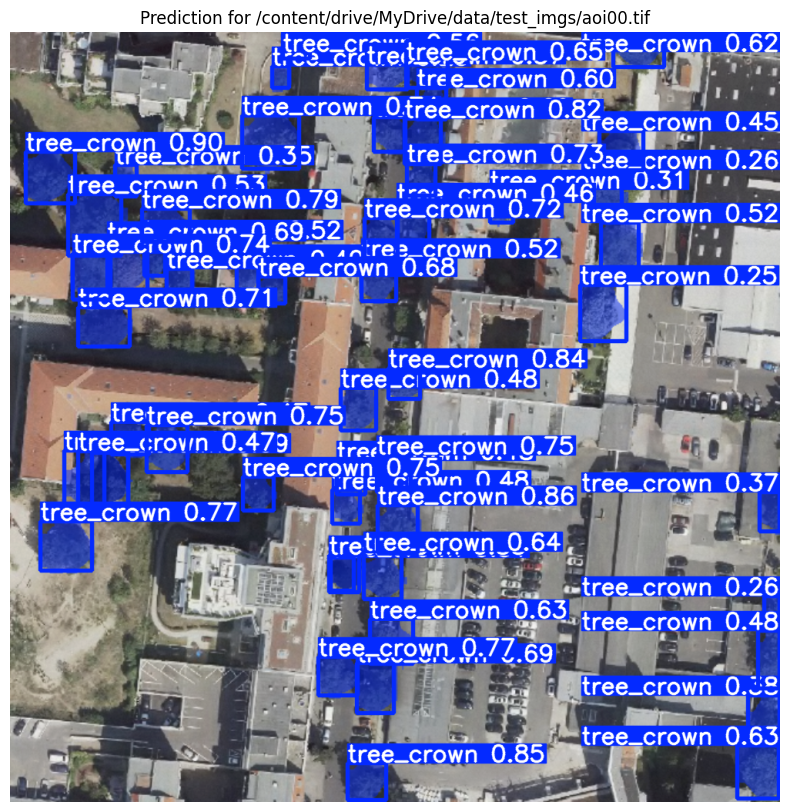

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load the trained model
#model = YOLO(model_path)

# Test on a single image
img_path = '/content/drive/MyDrive/data/test_imgs/aoi00.tif'

# Load the image with OpenCV
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load as is (e.g., to preserve bit depth)

# Ensure the image is loaded correctly
if img is None:
    print(f"Failed to load image: {img_path}")
else:
    # Convert to RGB if necessary
    if len(img.shape) == 2:  # Grayscale to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Run prediction on the preprocessed image
    results = model.predict(img)

    # Display the results using OpenCV (with matplotlib for plotting)
    result_img = results[0].plot()  # Get the result image with bounding boxes

    # Convert BGR to RGB for matplotlib (OpenCV loads images in BGR by default)
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(result_img_rgb)
    plt.axis('off')
    plt.title(f"Prediction for {img_path}")
    plt.show()



0: 640x640 54 tree_crowns, 50.4ms
Speed: 4.3ms preprocess, 50.4ms inference, 20.4ms postprocess per image at shape (1, 3, 640, 640)


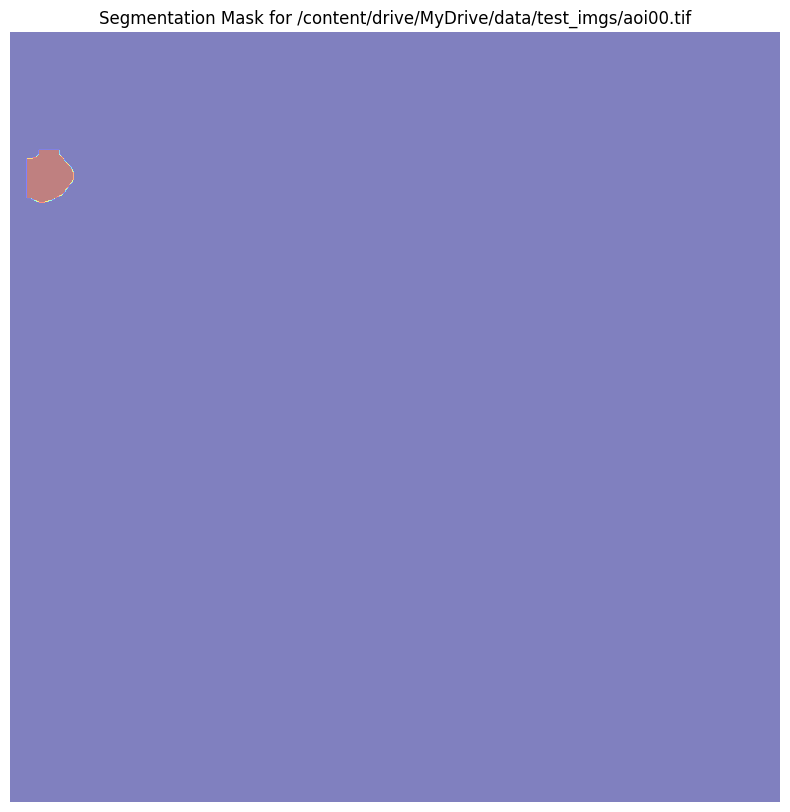

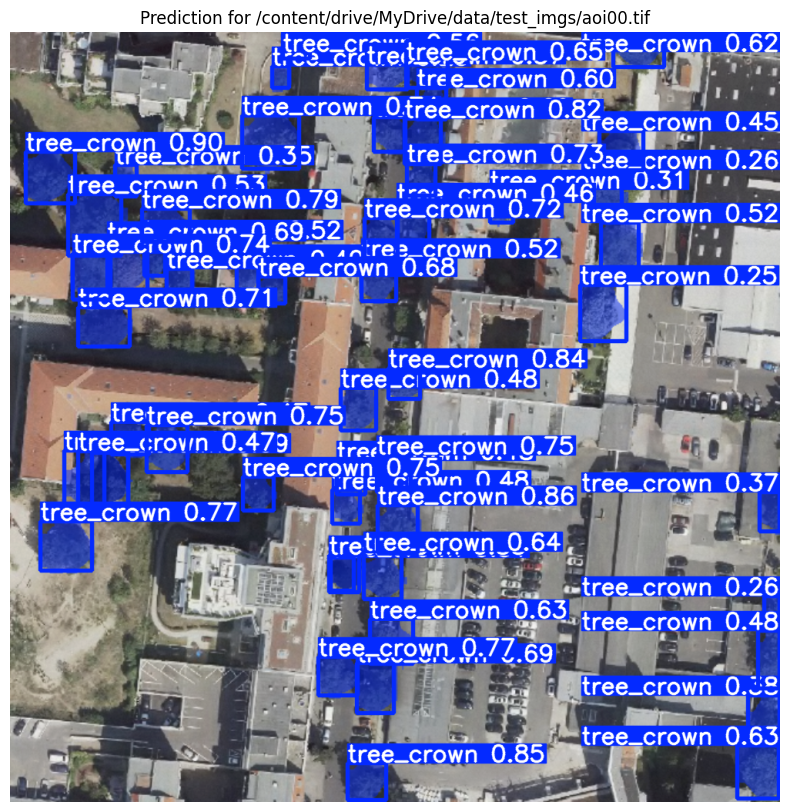

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Test on a single image
img_path = '/content/drive/MyDrive/data/test_imgs/aoi00.tif'

# Load the image with OpenCV
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load as is (e.g., to preserve bit depth)

# Ensure the image is loaded correctly
if img is None:
    print(f"Failed to load image: {img_path}")
else:
    # Convert to RGB if necessary
    if len(img.shape) == 2:  # Grayscale to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Run prediction on the preprocessed image
    results = model.predict(img)

    # Visualization of bounding boxes
    result_img = results[0].plot()  # Get the result image with bounding boxes
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Visualization of segmentation masks
    if results[0].masks is not None:
        mask_img = results[0].masks.data[0].cpu().numpy()  # Get the first mask (you can iterate for multiple masks)
        plt.figure(figsize=(10, 10))
        plt.imshow(mask_img, cmap='jet', alpha=0.5)  # Overlay mask with transparency
        plt.axis('off')
        plt.title(f"Segmentation Mask for {img_path}")
        plt.show()

    # Display the result with bounding boxes and masks
    plt.figure(figsize=(10, 10))
    plt.imshow(result_img_rgb)
    plt.axis('off')
    plt.title(f"Prediction for {img_path}")
    plt.show()



image 1/1 /content/drive/MyDrive/data/test_imgs/aoi00.tif: 640x640 12 tree_crowns, 51.3ms
Speed: 5.2ms preprocess, 51.3ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)
Results for /content/drive/MyDrive/data/test_imgs/aoi00.tif: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'tree_crown'}
obb: None
orig_img: array([[[133, 138, 152],
        [131, 137, 148],
        [127, 133, 144],
        ...,
        [104, 102, 112],
        [ 97,  96, 103],
        [ 83,  82,  89]],

       [[112, 118, 129],
        [109, 115, 126],
        [117, 123, 134],
        ...,
        [ 95,  92,  99],
        [ 92,  89,  96],
        [ 82,  79,  86]],

       [[ 96, 102, 113],
        [ 95, 101, 112],
        [ 97, 103, 114],
        ...,
        [ 96,  93, 100],
        [ 90,  87,  94],
        [ 88,  86,  91]],

       ...,

       [[177, 173, 169],
  

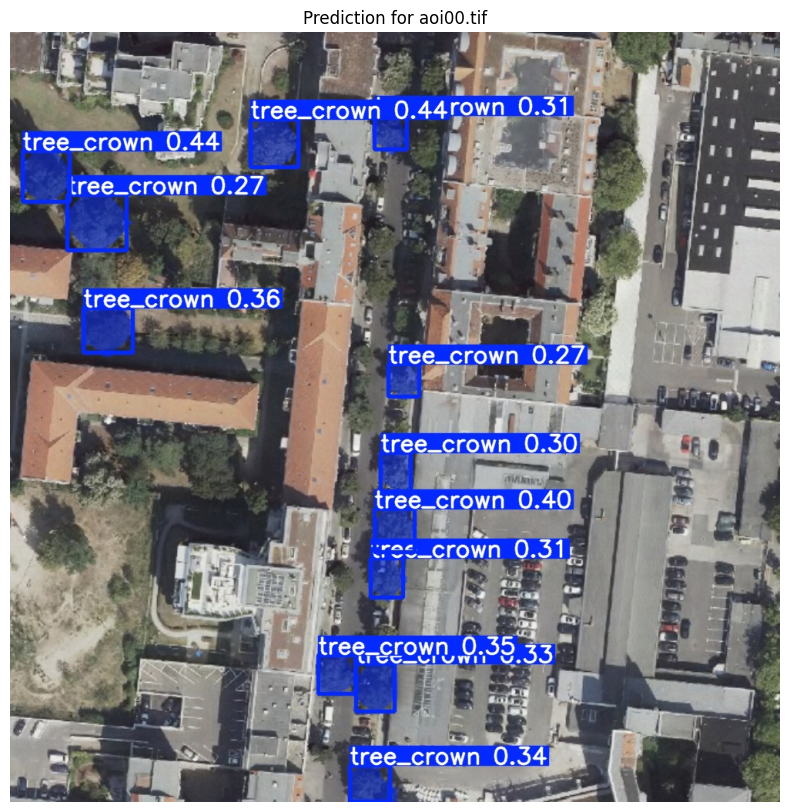


image 1/1 /content/drive/MyDrive/data/test_imgs/382_5826_9_6.tif: 640x640 (no detections), 50.4ms
Speed: 3.7ms preprocess, 50.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results for /content/drive/MyDrive/data/test_imgs/382_5826_9_6.tif: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'tree_crown'}
obb: None
orig_img: array([[[128, 100,  97],
        [136, 114, 108],
        [126, 106, 100],
        ...,
        [104, 111, 105],
        [ 93, 105,  98],
        [ 66,  80,  73]],

       [[133, 108, 104],
        [128, 108, 102],
        [126, 108, 101],
        ...,
        [ 75,  84,  78],
        [ 66,  78,  71],
        [ 77,  91,  84]],

       [[ 80,  57,  53],
        [ 89,  71,  64],
        [ 85,  69,  62],
        ...,
        [ 72,  81,  75],
        [ 68,  80,  73],
        [ 67,  81,  74]],

       ...,

       [[ 58,  52,  45],
        [ 52,  48,  41

In [ ]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt

# Path to the trained model weights
#trained_model_path = "runs/segment/train2/weights/best.pt"

# Load the trained model
#model = YOLO(trained_model_path)

# Path to the folder containing new test images
test_images_folder = "/content/drive/MyDrive/data/test_imgs"

# Output folder to save the predictions
output_folder = "/content/drive/MyDrive/data/test_predictions"
os.makedirs(output_folder, exist_ok=True)

# List all image files in the test_images_folder
test_images = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.tif'))]

# Run inference on each test image
for img_path in test_images:
    # Perform inference
    results = model.predict(img_path)

    # Debug: Print the results
    print(f"Results for {img_path}: {results}")

    if len(results) == 0 or len(results[0].boxes) == 0:
        print(f"No detections for image: {img_path}")
        continue

    # Save each result and plot
    for i, result in enumerate(results):
        # Generate the output file path
        output_file_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(img_path))[0]}_{i}.jpg")

        # Save the result
        result.plot(save=True, filename=output_file_path)

        # Plot the result using OpenCV
        img = cv2.imread(output_file_path)
        if img is None:
            print(f"Error reading the image file: {output_file_path}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Prediction for {os.path.basename(img_path)}")
        plt.show()

print(f"Predictions saved to {output_folder}")